# Walmart Sales

We want to predict sales for 3 following days. We train the model on the data from the one year, and use the last 30 days to predict 3 following days. We use the data from the Walmart Sales Forecasting competition.

In [22]:
import pandas as pd

from darts import TimeSeries
from utils import TimeseriesExperiment, Dataset
from datetime import timedelta


In [23]:
df_store = pd.read_csv('data/walmart-sales/stores.csv')

df_train = pd.read_csv('data/walmart-sales/train.csv')

df_features = pd.read_csv('data/walmart-sales/features.csv')

# Get data from one store
df = df_train[df_train['Store'] == 1]
df = df[df['Dept'] == 1]
# TODO: Use is holiday parameter
df = df.drop(['Store', 'Dept', 'IsHoliday'], axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').resample('W').mean()


df.head()

,Weekly_Sales
Date,
2010-02-07,24924.50
2010-02-14,46039.49
2010-02-21,41595.55
2010-02-28,19403.54
2010-03-07,21827.90


In [24]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import StandardScaler

def get_series_from_dataframe(dataframe):
    result = TimeSeries.from_dataframe(dataframe, freq='W', fill_missing_dates=True)
    split_point = result.end_time() - timedelta(weeks=52)
    result = result.drop_before(split_point)

    return result

series = get_series_from_dataframe(df)

ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='B'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases


ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='B'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

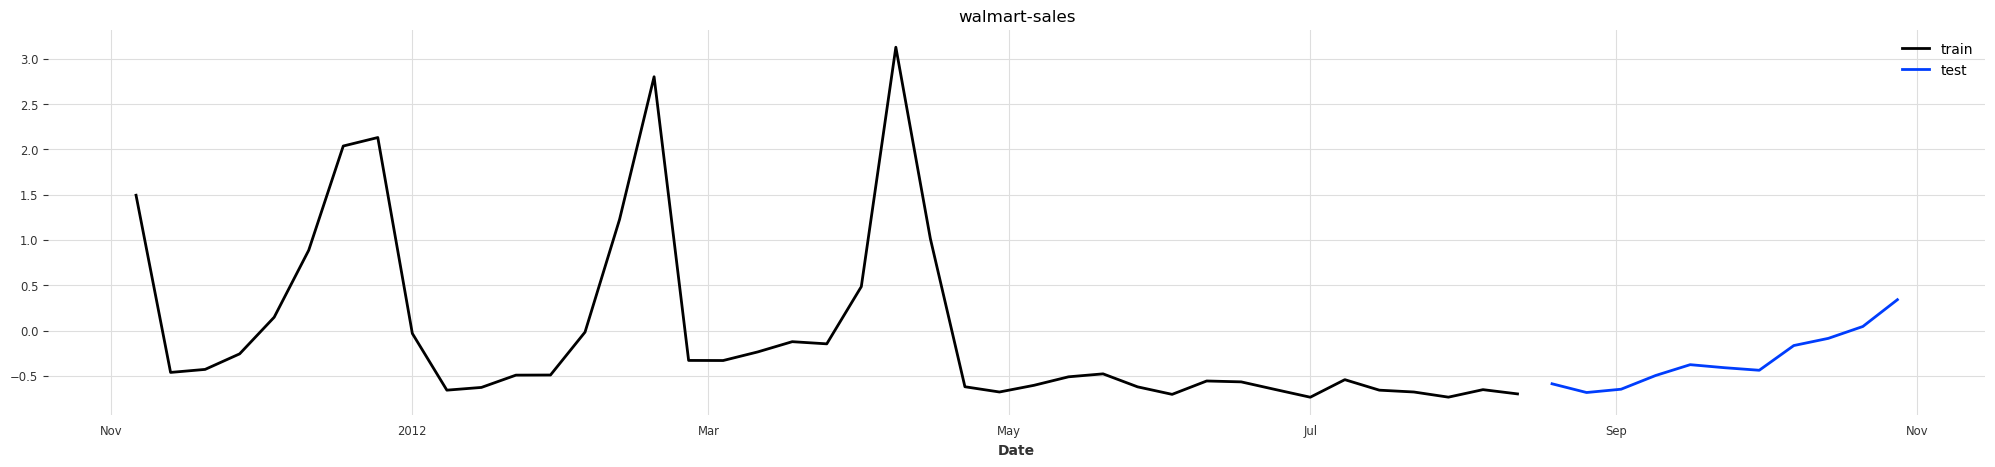

2012-08-12 00:00:00
2012-08-19 00:00:00


In [ ]:
dataset = Dataset(series, 'walmart-sales')
dataset.plot_train_test()

print(dataset.train.time_index[-1])
print(dataset.test.time_index[0])

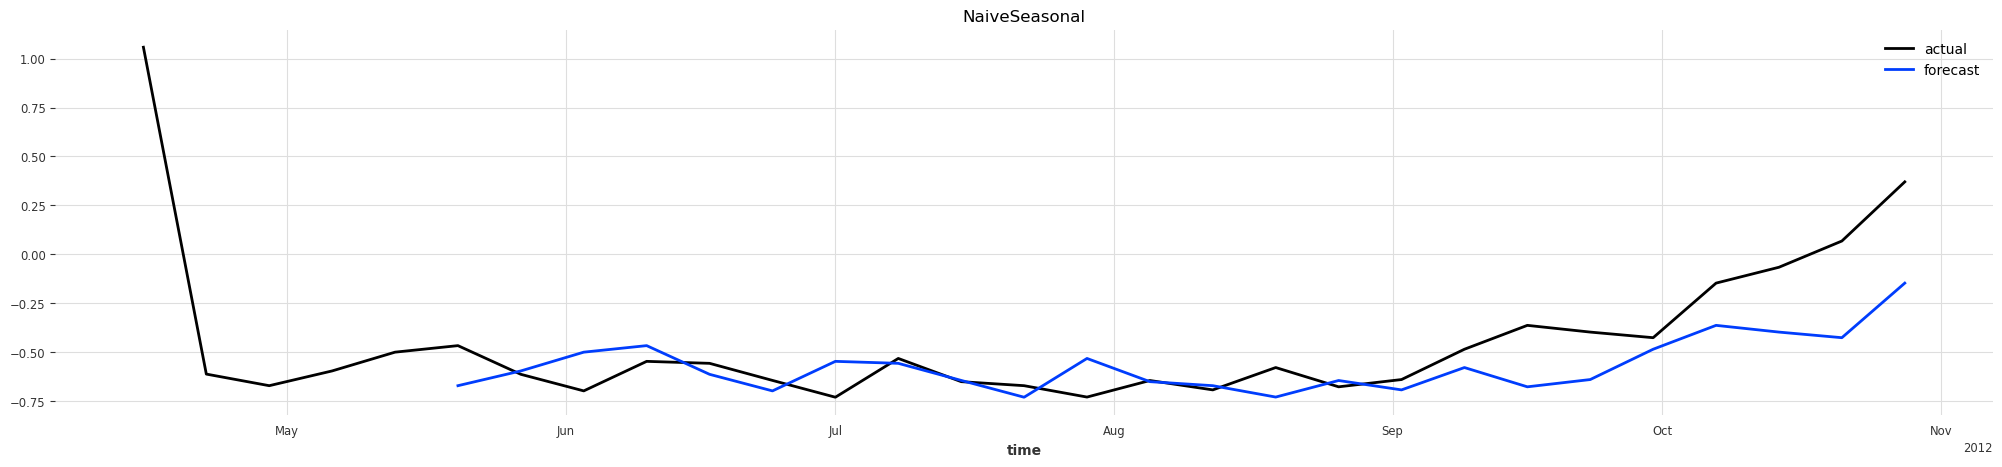

{'mape': 100.00323048857831,
 'mse': 345995538.9766026,
 'rmse': 18600.95532429995,
 'mae': 18376.598398421655,
 'model': 'NaiveSeasonal',
 'forecast_horizon': 3,
 'dataset': 'walmart-sales',
 'experiment_time': 1716130312.737539,
 'parameters': OrderedDict([('K', 1)])}

In [ ]:
from darts.models import NaiveSeasonal

model = NaiveSeasonal(K=1)

experiment1 = TimeseriesExperiment(model, dataset, retrain=True)

experiment1.run()

In [ ]:
# arima
from darts.models import ARIMA

model = ARIMA()

experiment2 = TimeseriesExperiment(model, dataset, {
    'p': [1, 3, 5],
    'd': [1],
    'q': [0]
}, retrain=True)

experiment2.run()

ValueError: Cannot build a single input for prediction with the provided model, `series` and `*_covariates` at series index: 0. The minimum prediction input time index requirements were not met. Please check the time index of `series` and `*_covariates`.


ValueError: Cannot build a single input for prediction with the provided model, `series` and `*_covariates` at series index: 0. The minimum prediction input time index requirements were not met. Please check the time index of `series` and `*_covariates`.

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


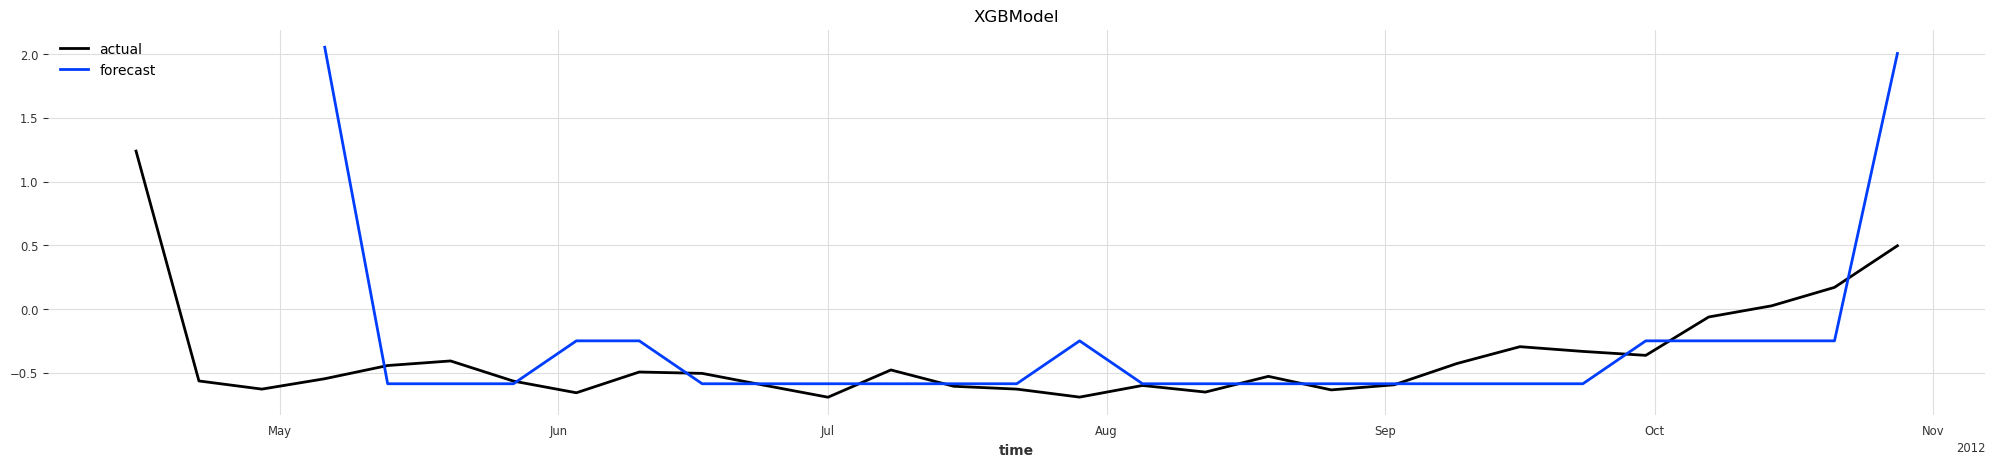

{'mape': 115.4417192518936,
 'mse': 0.38573230514645623,
 'rmse': 0.6210735102598212,
 'mae': 0.3002798065957005,
 'model': 'XGBModel',
 'forecast_horizon': 3,
 'dataset': 'walmart-sales',
 'experiment_time': 1716128349.719647,
 'parameters': OrderedDict([('lags', 1),
              ('lags_past_covariates', None),
              ('lags_future_covariates', None),
              ('output_chunk_length', 1),
              ('output_chunk_shift', 0),
              ('add_encoders', None),
              ('likelihood', None),
              ('quantiles', None),
              ('random_state', None),
              ('multi_models', True),
              ('use_static_covariates', True),
              ('max_depth', 3),
              ('n_estimators', 50)])}

In [ ]:
from darts.models import XGBModel

model = XGBModel(
    lags=1,
)

experiment3 = TimeseriesExperiment(model, dataset, {
    'lags': [3, 7, 14],
    'max_depth': [3, 5, 7],
    'n_estimators': [10, 25, 50, 100],
    'output_chunk_length': [1, 3],
})

experiment3.run()

16:19:09 - cmdstanpy - INFO - Chain [1] start processing
16:19:09 - cmdstanpy - INFO - Chain [1] done processing
16:19:09 - cmdstanpy - INFO - Chain [1] start processing
16:19:09 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1]

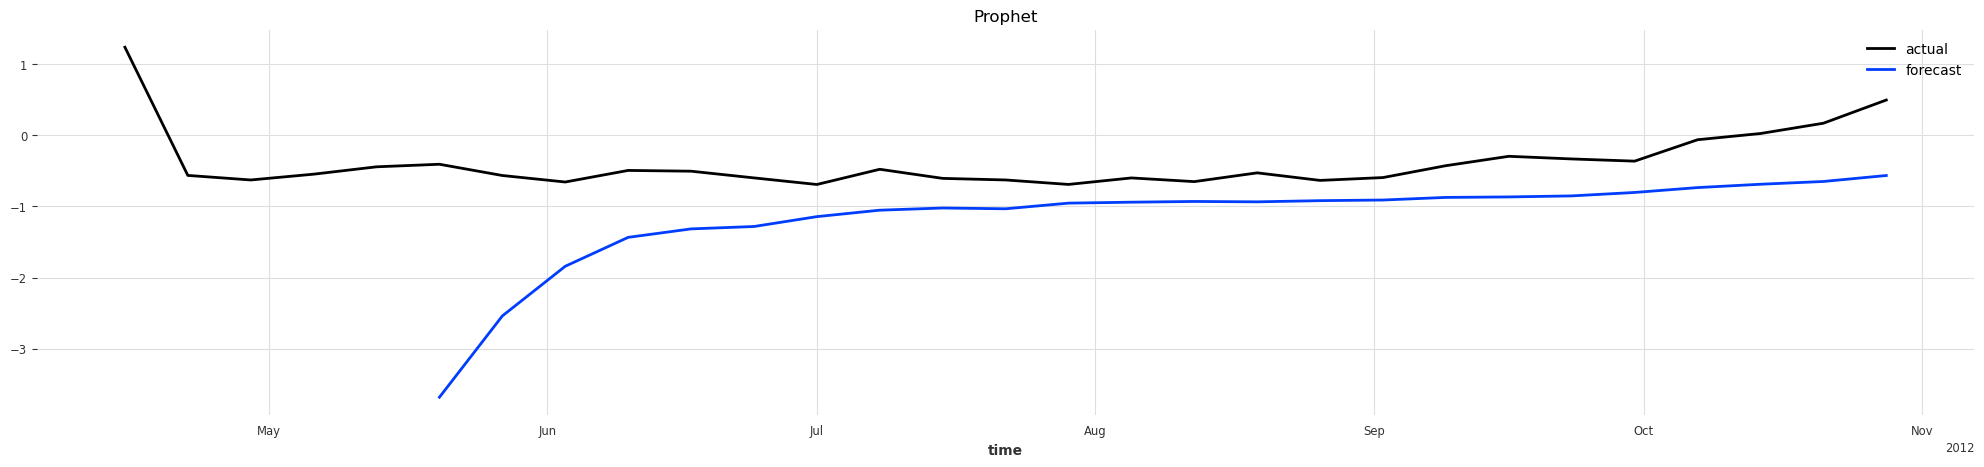

{'mape': 316.090209094024,
 'mse': 0.9706541061997527,
 'rmse': 0.9852177963271638,
 'mae': 0.7442877167242804,
 'model': 'Prophet',
 'forecast_horizon': 3,
 'dataset': 'walmart-sales',
 'experiment_time': 1716128351.2286222,
 'parameters': OrderedDict([('add_seasonalities', None),
              ('country_holidays', None),
              ('suppress_stdout_stderror', True),
              ('add_encoders', None),
              ('cap', None),
              ('floor', None)])}

In [ ]:
from darts.models import Prophet

model_prophet = Prophet()

experiment_prophet = TimeseriesExperiment(model_prophet, dataset, retrain=True)

experiment_prophet.run()

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/t

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


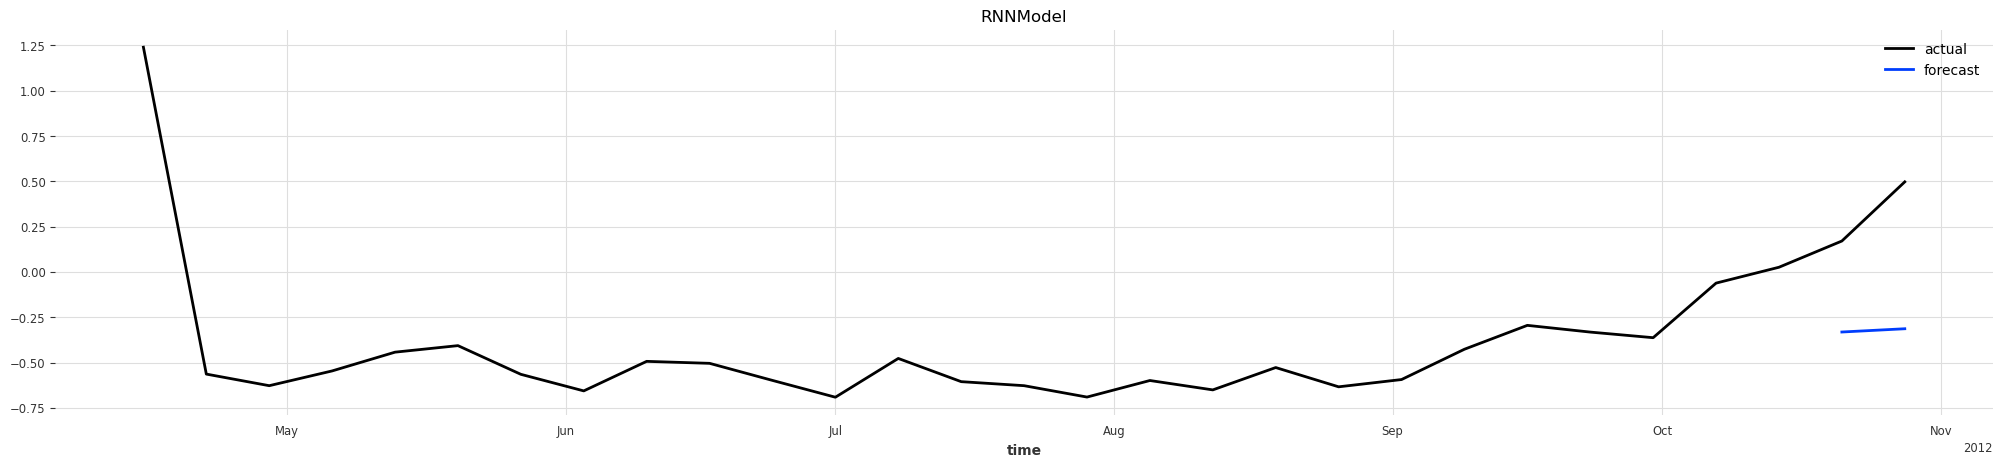

{'mape': 229.00097674845955,
 'mse': 0.454403605823413,
 'rmse': 0.6740946564269835,
 'mae': 0.6562162574035091,
 'model': 'RNNModel',
 'forecast_horizon': 3,
 'dataset': 'walmart-sales',
 'experiment_time': 1716128357.202425,
 'parameters': OrderedDict([('model', 'LSTM'),
              ('hidden_dim', 20),
              ('n_rnn_layers', 1),
              ('dropout', 0.1),
              ('training_length', 24),
              ('batch_size', 16),
              ('n_epochs', 100),
              ('optimizer_kwargs', {'lr': 0.001}),
              ('model_name', 'LSTM'),
              ('log_tensorboard', True),
              ('input_chunk_length', 1),
              ('random_state', 42),
              ('pl_trainer_kwargs', {'accelerator': 'cpu'})])}

In [ ]:
from darts.models.forecasting.rnn_model import RNNModel

lstm_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0.1,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    model_name='LSTM',
    input_chunk_length=1,
    random_state=42,
    pl_trainer_kwargs={'accelerator': 'cpu'}
)

experiment_lstm = TimeseriesExperiment(lstm_model, dataset, retrain=True)

experiment_lstm.run()